In [ ]:
!pip install -q transformers accelerate opencv-python-headless pillow open_clip_torch numpy matplotlib


In [19]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import open_clip

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cpu


In [27]:
# Load OWL-ViT

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch16",revision="refs/pr/6")
owlvit = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch16",revision="refs/pr/6").to(DEVICE)

print(owlvit.config)


# Load CLIP
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
tokenizer = open_clip.get_tokenizer("ViT-B-32")

clip_model = clip_model.to(DEVICE)
clip_model.eval()


c:\Users\MUNI SAI\Downloads\DeepLearning\Project\dlenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MUNI SAI\.cache\huggingface\hub\models--google--owlvit-base-patch16. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


OwlViTConfig {
  "architectures": [
    "OwlViTForObjectDetection"
  ],
  "dtype": "float32",
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "owlvit",
  "projection_dim": 512,
  "text_config": {
    "attention_dropout": 0.0,
    "bos_token_id": 0,
    "dropout": 0.0,
    "dtype": "float32",
    "eos_token_id": 2,
    "hidden_act": "quick_gelu",
    "hidden_size": 512,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 2048,
    "layer_norm_eps": 1e-05,
    "max_position_embeddings": 16,
    "model_type": "owlvit_text_model",
    "num_attention_heads": 8,
    "num_hidden_layers": 12,
    "pad_token_id": 1,
    "vocab_size": 49408
  },
  "text_config_dict": null,
  "transformers_version": "4.57.1",
  "vision_config": {
    "attention_dropout": 0.0,
    "dropout": 0.0,
    "dtype": "float32",
    "hidden_act": "quick_gelu",
    "hidden_size": 768,
    "image_size": 768,
    "initializer_factor": 1.0,
    "initializer_ra

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [28]:
def normalize(v):
    return v / (np.linalg.norm(v) + 1e-10)

def cosine(a, b):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def pil_from_bgr(frame):
    return Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

@torch.no_grad()
def encode_image(pil_img):
    img = clip_preprocess(pil_img).unsqueeze(0).to(DEVICE)
    emb = clip_model.encode_image(img)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb[0].cpu().numpy()

@torch.no_grad()
def encode_text(text):
    tokens = tokenizer([text]).to(DEVICE)
    emb = clip_model.encode_text(tokens)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb[0].cpu().numpy()

def fuse_embeddings(img_emb=None, txt_emb=None):
    if img_emb is not None and txt_emb is not None:
        return normalize(img_emb + txt_emb)
    if img_emb is not None:
        return img_emb
    if txt_emb is not None:
        return txt_emb
    raise ValueError("No query provided")


In [29]:
@torch.no_grad()
def detect_with_owlvit(frame, text_query=None, image_query_path=None, score_threshold=0.1):
    pil_img = pil_from_bgr(frame)

    # -----------------------------
    # CASE 1: TEXT QUERY
    # -----------------------------
    if text_query is not None:
        inputs = processor(
            text=[text_query], 
            images=pil_img,
            return_tensors="pt"
        ).to(DEVICE)

        # Use full inputs for text mode
        outputs = owlvit(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"]
        )

    # -----------------------------
    # CASE 2: IMAGE QUERY (image-guided detection)
    # -----------------------------
    elif image_query_path is not None:
        query_img = Image.open(image_query_path).convert("RGB")

        # Image-guided detection uses *two images*
        inputs = processor(
            images=[query_img, pil_img],
            return_tensors="pt"
        ).to(DEVICE)

        # For image queries → DO NOT pass input_ids
        outputs = owlvit(
            pixel_values=inputs["pixel_values"]
        )

    # -----------------------------
    # POST-PROCESSING
    # -----------------------------
    target_sizes = torch.tensor([pil_img.size[::-1]]).to(DEVICE)
    results = processor.post_process(outputs, target_sizes=target_sizes)[0]

    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()

    valid = scores > score_threshold
    return boxes[valid], scores[valid]


In [30]:
def run_owlvit_clip_matching(
        frame,
        text_query=None,
        image_query_path=None,
        sim_threshold=0.28
    ):
    
    # Step 1: Encode query
    if text_query is None or str(text_query).strip() == "":
        txt_emb = None
    else:
        txt_emb = encode_text(text_query)

    # Image embedding only if REAL image path exists
    if image_query_path is None or str(image_query_path).strip() == "":
        img_emb = None
    else:
        img_emb = encode_image(Image.open(image_query_path))
    
    query_emb = fuse_embeddings(img_emb, txt_emb)

    # Step 2: Detect with OWL-ViT
    boxes, scores = detect_with_owlvit(frame, text_query, image_query_path)

    similarities = []
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        crop = frame[y1:y2, x1:x2]
        crop_pil = pil_from_bgr(crop)

        emb = encode_image(crop_pil)
        sim = cosine(emb, query_emb)
        similarities.append(sim)

    # Step 3: Visualization
    vis = frame.copy()
    for box, sim in zip(boxes, similarities):
        x1, y1, x2, y2 = map(int, box)
        color = (0,255,0) if sim > sim_threshold else (0,0,255)
        cv2.rectangle(vis, (x1,y1), (x2,y2), color, 2)
        cv2.putText(vis, f"{sim:.2f}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(12,8))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return boxes, similarities


c:\Users\MUNI SAI\Downloads\DeepLearning\Project\dlenv\Lib\site-packages\transformers\models\owlvit\image_processing_owlvit.py:465: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(


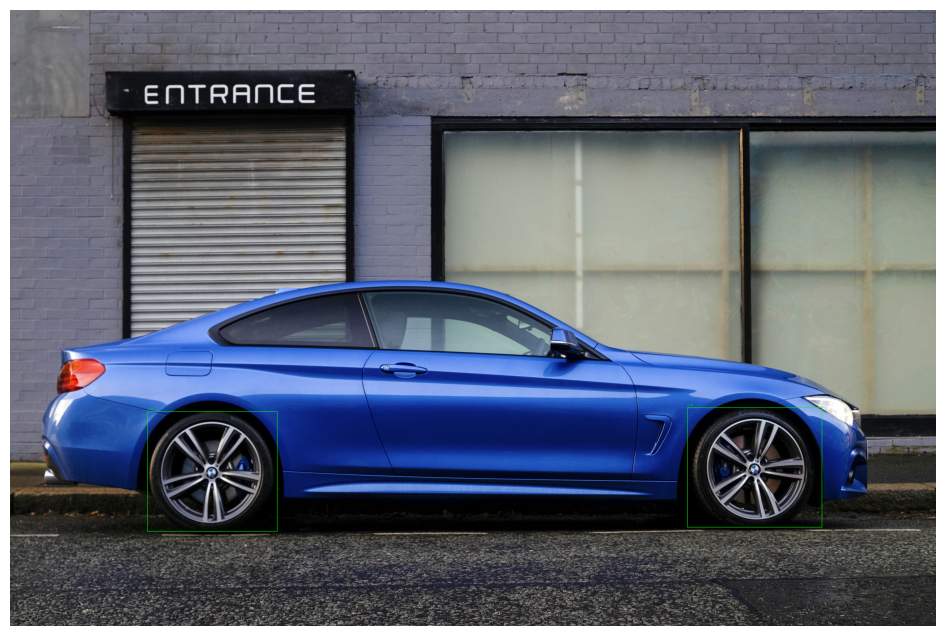

(array([[ 870.46796, 2542.7969 , 1691.6873 , 3301.2087 ],
        [4286.9707 , 2517.1797 , 5137.689  , 3275.736  ]], dtype=float32),
 [0.2859494686126709, 0.2837076187133789])

In [32]:
frame = cv2.imread("input_image.png")
run_owlvit_clip_matching(frame, text_query="wheel")


In [33]:
run_owlvit_clip_matching(
    frame,
    image_query_path="image_1.png"
)


TypeError: OwlViTForObjectDetection.forward() missing 1 required positional argument: 'input_ids'

c:\Users\MUNI SAI\Downloads\DeepLearning\Project\dlenv\Lib\site-packages\transformers\models\owlvit\image_processing_owlvit.py:465: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(


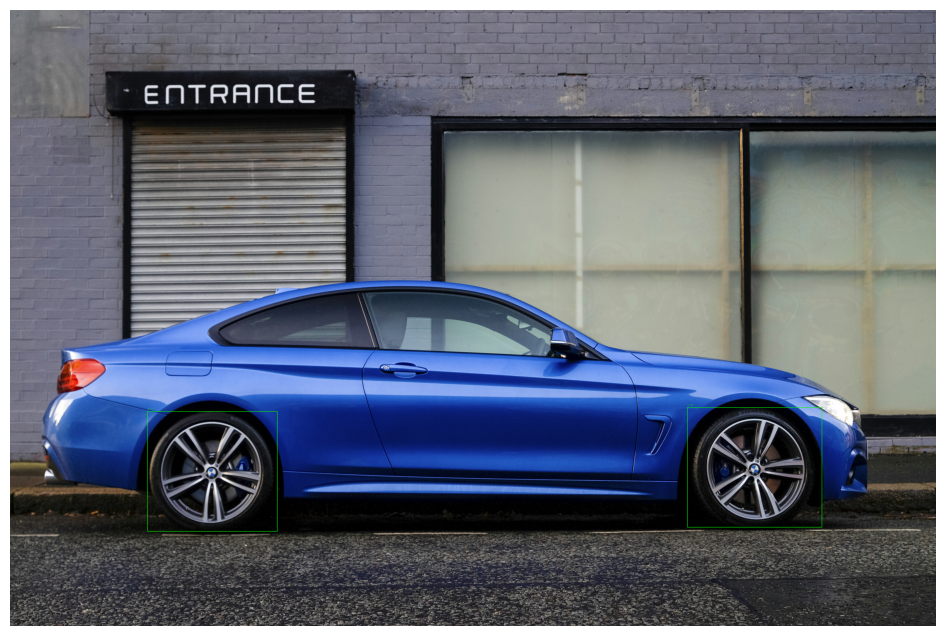

(array([[ 870.46796, 2542.7969 , 1691.6873 , 3301.2087 ],
        [4286.9707 , 2517.1797 , 5137.689  , 3275.736  ]], dtype=float32),
 [0.7743830680847168, 0.777401864528656])

In [27]:
run_owlvit_clip_matching(
    frame,
    text_query="wheel",
    image_query_path="image_2.png"
)


### Video

In [23]:
from tqdm import tqdm

In [24]:
def match_frame(frame, query_emb, text_query=None, image_query_path=None, sim_threshold=0.25):
    print("DEBUG text_query =", repr(text_query))
    print("DEBUG image_query_path =", repr(image_query_path))

    import cv2
    from PIL import Image
    import numpy as np
    import torch

    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # --- FORCE CLEAN INPUTS ---
    if text_query is None:
        text_query_clean = None
    elif str(text_query).strip() == "":
        text_query_clean = None
    else:
        text_query_clean = text_query

    if image_query_path is None:
        image_query_clean = None
    else:
        image_query_clean = image_query_path

    # --- CASE 1: IMAGE ONLY ---
    if image_query_clean is not None and text_query_clean is None:
        query_img = Image.open(image_query_clean).convert("RGB")
        inputs = processor(
            images=[query_img, pil_img],
            return_tensors="pt"
        ).to(DEVICE)

    # --- CASE 2: TEXT ONLY ---
    elif text_query_clean is not None and image_query_clean is None:
        inputs = processor(
            text=[text_query_clean],
            images=pil_img,
            return_tensors="pt"
        ).to(DEVICE)

    # --- CASE 3: BOTH ---
    elif text_query_clean and image_query_clean:
        query_img = Image.open(image_query_clean).convert("RGB")
        inputs = processor(
            text=[text_query_clean],
            images=[query_img, pil_img],
            return_tensors="pt"
        ).to(DEVICE)

    else:
        raise ValueError("You must provide text_query, image_query_path, or both.")

    # RUN OWLVIT
    with torch.no_grad():
        print(inputs.keys())
        outputs = owlvit(**inputs)

    # POST PROCESS
    results = processor.post_process_object_detection(
        outputs,
        threshold=0.15,
        target_sizes=[pil_img.size[::-1]]
    )[0]

    boxes = results["boxes"]

    # ---- CLIP similarity ----
    final_boxes = []
    final_sims = []

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        crop = frame[y1:y2, x1:x2]

        pil_crop = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        crop_t = clip_preprocess(pil_crop).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            emb = clip_model.encode_image(crop_t)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            emb = emb[0].cpu().numpy()

        sim = float(np.dot(query_emb, emb))
        if sim >= sim_threshold:
            final_boxes.append([x1, y1, x2, y2])
            final_sims.append(sim)

    return final_boxes, final_sims


In [25]:
def search_in_video(
        video_path,
        output_path,
        text_query=None,
        image_query_path=None,
        sim_threshold=0.28,
        frame_skip=1):

    # STEP 1 — Create Query Embedding
    if text_query is None or str(text_query).strip() == "":
        txt_emb = None
    else:
        txt_emb = encode_text(text_query)

    # Image embedding only if REAL image path exists
    if image_query_path is None or str(image_query_path).strip() == "":
        img_emb = None
    else:
        img_emb = encode_image(Image.open(image_query_path))
    query_emb = fuse_embeddings(img_emb, txt_emb)

    # STEP 2 — Open Video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # STEP 3 — Output Video Writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (W, H))

    results = []

    for frame_id in tqdm(range(total_frames)):
        ret, frame = cap.read()
        frame = cv2.resize(frame, (640, 640))
        if not ret:
            break



        if frame_id % frame_skip != 0:
            out.write(frame)
            continue

        # MATCH CURRENT FRAME
        boxes, similarities = match_frame(
            frame, 
            query_emb,
            text_query=text_query,
            image_query_path=image_query_path,
            sim_threshold=sim_threshold
        )

        # DRAW + SAVE RESULTS
        for box, sim in zip(boxes, similarities):
            x1,y1,x2,y2 = map(int, box)
            color = (0,255,0) if sim > sim_threshold else (0,0,255)
            cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
            cv2.putText(frame, f"{sim:.2f}", (x1,y1-8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            if sim > sim_threshold:
                timestamp = frame_id / fps
                results.append((frame_id, timestamp, sim, (x1,y1,x2,y2)))

        out.write(frame)

    cap.release()
    out.release()

    print("Output saved to:", output_path)
    return results


In [10]:
results = search_in_video(
    video_path="input_2.mp4",
    output_path="output_owlvit_wheelimg.mp4",
    image_query_path="handbag.png"
)


  0%|          | 0/1317 [00:00<?, ?it/s]

DEBUG text_query = None
DEBUG image_query_path = 'handbag.png'


  0%|          | 0/1317 [00:00<?, ?it/s]

KeysView({'pixel_values': tensor([[[[-0.6098, -0.6098, -0.6098,  ..., -0.9456, -0.9310, -0.9456],
          [-0.6098, -0.6098, -0.6098,  ..., -0.9310, -0.9310, -0.9456],
          [-0.6098, -0.6098, -0.6098,  ..., -0.9310, -0.9310, -0.9456],
          ...,
          [ 1.0836,  1.0836,  1.0836,  ..., -1.2521, -1.2521, -1.2521],
          [ 1.0836,  1.0836,  1.0836,  ..., -1.2521, -1.2521, -1.2521],
          [ 1.0836,  1.0836,  1.0836,  ..., -1.2521, -1.2521, -1.2521]],

         [[-0.5065, -0.5065, -0.5065,  ..., -0.5215, -0.5065, -0.5215],
          [-0.5065, -0.5065, -0.5065,  ..., -0.5065, -0.5065, -0.5215],
          [-0.5065, -0.5065, -0.5065,  ..., -0.5065, -0.5065, -0.5215],
          ...,
          [ 1.6697,  1.6697,  1.6697,  ..., -0.8516, -0.8516, -0.8516],
          [ 1.6697,  1.6697,  1.6697,  ..., -0.8516, -0.8516, -0.8516],
          [ 1.6697,  1.6697,  1.6697,  ..., -0.8516, -0.8516, -0.8516]],

         [[-0.0724, -0.0724, -0.0724,  ...,  0.2546,  0.2546,  0.2404],
    

TypeError: OwlViTForObjectDetection.forward() missing 1 required positional argument: 'input_ids'

In [11]:
# FULL RESET
%reset -f

import gc, torch
gc.collect()
torch.cuda.empty_cache()


In [12]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch16")
owlvit = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch16").to(DEVICE)

print(owlvit.config)


NameError: name 'DEVICE' is not defined

In [21]:
results = search_in_video(
    video_path="input_2.mp4",
    output_path="output_owlvit_carwheel.mp4",
    text_query="handbag"
)


  0%|          | 0/1317 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [26]:
results = search_in_video(
    video_path="input_2.mp4",
    output_path="output_owlvit_wheelimg.mp4",
    text_query="handbag",
    image_query_path="handbag.png"
)

  0%|          | 0/1317 [00:00<?, ?it/s]

DEBUG text_query = 'handbag'
DEBUG image_query_path = 'handbag.png'
KeysView({'input_ids': tensor([[49406, 22654, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'pixel_values': tensor([[[[-0.6098, -0.6098, -0.6098,  ..., -0.9456, -0.9310, -0.9456],
          [-0.6098, -0.6098, -0.6098,  ..., -0.9310, -0.9310, -0.9456],
          [-0.6098, -0.6098, -0.6098,  ..., -0.9310, -0.9310, -0.9456],
          ...,
          [ 1.0836,  1.0836,  1.0836,  ..., -1.2521, -1.2521, -1.2521],
          [ 1.0836,  1.0836,  1.0836,  ..., -1.2521, -1.2521, -1.2521],
          [ 1.0836,  1.0836,  1.0836,  ..., -1.2521, -1.2521, -1.2521]],

         [[-0.5065, -0.5065, -0.5065,  ..., -0.5215, -0.5065, -0.5215],
          [-0.5065, -0.5065, -0.5065,  ..., -0.5065, -0.5065, -0.5215],
          [-0.5065, -0.5065, -0.5065,  ..., -0.5065, -0.5065, -0.5215],
          ...,
  

  0%|          | 0/1317 [00:17<?, ?it/s]


RuntimeError: shape '[2, 0, 512]' is invalid for input of size 512

In [30]:
print(processor)

OwlViTProcessor:
- image_processor: OwlViTImageProcessor {
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "OwlViTImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "OwlViTProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='google/owlvit-base-patch16', vocab_size=49408, model_max_length=16, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '!'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("!", rstrip=False, lstrip=False, single_word=Fa

In [31]:
print(owlvit.config)


OwlViTConfig {
  "architectures": [
    "OwlViTForObjectDetection"
  ],
  "dtype": "float32",
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "owlvit",
  "projection_dim": 512,
  "text_config": {
    "attention_dropout": 0.0,
    "bos_token_id": 0,
    "dropout": 0.0,
    "dtype": "float32",
    "eos_token_id": 2,
    "hidden_act": "quick_gelu",
    "hidden_size": 512,
    "initializer_factor": 1.0,
    "initializer_range": 0.02,
    "intermediate_size": 2048,
    "layer_norm_eps": 1e-05,
    "max_position_embeddings": 16,
    "model_type": "owlvit_text_model",
    "num_attention_heads": 8,
    "num_hidden_layers": 12,
    "pad_token_id": 1,
    "vocab_size": 49408
  },
  "text_config_dict": null,
  "transformers_version": "4.57.1",
  "vision_config": {
    "attention_dropout": 0.0,
    "dropout": 0.0,
    "dtype": "float32",
    "hidden_act": "quick_gelu",
    "hidden_size": 768,
    "image_size": 768,
    "initializer_factor": 1.0,
    "initializer_ra

NameError: name 'text_query' is not defined

In [1]:
# In a notebook cell prefix with ! for shell commands
!pip install transformers[torch] torchvision pillow opencv-python ftfy accelerate
!pip install sentence-transformers  # optional if you want other embedding helpers


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\MUNI SAI\Downloads\DeepLearning\Project\dlenv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\MUNI SAI\Downloads\DeepLearning\Project\dlenv\Scripts\python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [2]:
# Cell 1: imports
from transformers import pipeline, CLIPProcessor, CLIPModel
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import os, json, math, time
from collections import defaultdict
from torchvision.ops import nms


c:\Users\MUNI SAI\Downloads\DeepLearning\project_github\CCTV_surveillance\dlenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cell 2: load models
# OWL zero-shot detector (returns boxes + labels)
owl_model_name = "google/owlvit-base-patch32"  # change to a larger OWL if you have GPU/VRAM
owl = pipeline("zero-shot-object-detection", model=owl_model_name, device=0 if torch.cuda.is_available() else -1)

# CLIP (for mapping exemplar image -> candidate labels)
clip_model_name = "openai/clip-vit-base-patch32"
clip = CLIPModel.from_pretrained(clip_model_name).eval().to("cuda" if torch.cuda.is_available() else "cpu")
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu
c:\Users\MUNI SAI\Downloads\DeepLearning\project_github\CCTV_surveillance\dlenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MUNI SAI\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitation

In [4]:
# Cell 3: COCO-ish label set (useful as candidate label vocabulary for exemplar mapping)
COCO_LABELS = [
    "person","bicycle","car","motorbike","aeroplane","bus","train","truck","boat",
    "traffic light","fire hydrant","stop sign","parking meter","bench","bird","cat",
    "dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack","umbrella",
    "handbag","tie","suitcase","frisbee","skis","snowboard","sports ball","kite","baseball bat",
    "baseball glove","skateboard","surfboard","tennis racket","bottle","wine glass","cup","fork",
    "knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hot dog",
    "pizza","donut","cake","chair","sofa","pottedplant","bed","diningtable","toilet","tvmonitor",
    "laptop","mouse","remote","keyboard","cell phone","microwave","oven","toaster","sink","refrigerator",
    "book","clock","vase","scissors","teddy bear","hair drier","toothbrush"
]


In [5]:
# Cell 4: helpers - video -> frames (with frame indices & timestamps)
def extract_frames(video_path, max_frames=None, target_fps=None):
    """
    Returns list of (frame_idx, timestamp_s, frame_bgr) tuples.
    If target_fps is set, we sample to that fps.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError("Cannot open video: " + video_path)
    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    results = []
    frame_idx = 0
    sample_step = 1
    if target_fps and target_fps > 0:
        sample_step = max(1, int(round(orig_fps / target_fps)))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % sample_step == 0:
            timestamp_s = frame_idx / orig_fps
            results.append((frame_idx, timestamp_s, frame.copy()))
            if max_frames and len(results) >= max_frames:
                break
        frame_idx += 1
    cap.release()
    return results, orig_fps


In [6]:
# Cell 5: helpers - draw boxes, convert
def draw_boxes_on_pil(pil_img, detections, box_color=(255,0,0)):
    draw = ImageDraw.Draw(pil_img)
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 14)
    except:
        font = ImageFont.load_default()
    for det in detections:
        box = det["box"]  # [x0,y0,x1,y1] per OWL pipeline
        label = det.get("label", "")
        score = det.get("score", 0.0)
        draw.rectangle(box, outline=box_color, width=2)
        draw.text((box[0], max(0, box[1]-12)), f"{label} {score:.2f}", fill=box_color, font=font)
    return pil_img


In [7]:
# Cell 6: use CLIP to map exemplar image to top-k candidate labels from COCO_LABELS
def exemplar_to_labels(exemplar_pil, labels_list=COCO_LABELS, top_k=3, device=None):
    """
    Returns top_k textual labels from labels_list most similar to exemplar image using CLIP.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    # preprocess text and image
    texts = labels_list
    inputs = clip_processor(text=texts, images=exemplar_pil, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        image_emb = clip.get_image_features(inputs["pixel_values"].unsqueeze(0) if "pixel_values" in inputs else inputs["pixel_values"])
        text_emb = clip.get_text_features(inputs["input_ids"], inputs.get("attention_mask"))
        # Note: processor already returns text input tensors for text+image; but easier: compute separately below
    # Simpler compute: process separately
    text_inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    image_inputs = clip_processor(images=exemplar_pil, return_tensors="pt").to(device)
    with torch.no_grad():
        i_emb = clip.get_image_features(**{k:image_inputs[k].to(device) for k in image_inputs})
        t_emb = clip.get_text_features(**{k:text_inputs[k].to(device) for k in text_inputs})
    # normalize and compute similarities
    i_emb = i_emb / i_emb.norm(p=2, dim=-1, keepdim=True)
    t_emb = t_emb / t_emb.norm(p=2, dim=-1, keepdim=True)
    sims = (i_emb @ t_emb.T).squeeze(0).cpu().numpy()  # similarity to each text token
    best_idx = sims.argsort()[::-1][:top_k]
    chosen = [labels_list[i] for i in best_idx]
    scores = [float(sims[i]) for i in best_idx]
    return list(zip(chosen, scores))


In [8]:
# Cell 7: run OWL on single frame with candidate_labels
def run_owl_on_frame(pil_img, candidate_labels, threshold=0.35, return_all=False):
    """
    Uses owl pipeline on PIL image; returns detections filtered by threshold.
    Each detection format: {'score','label','box'} with box [x0,y0,x1,y1]
    """
    res = owl(pil_img, candidate_labels, threshold=threshold)
    # pipeline returns a list of detections; already filtered by threshold
    if return_all:
        return res
    else:
        # unify structure
        return [{"score": r["score"], "label": r["label"], "box": r["box"]} for r in res]


In [24]:
# Cell 8: per-frame detection wrapper for three modes
def detect_in_video(video_path, mode="text-only", user_text=None, exemplar_path=None,
                    sample_fps=None, owl_threshold=0.35, topk_from_exemplar=3):
    """
    mode: "text-only", "image-only", "image+text"
    user_text: string (for text-only or image+text)
    exemplar_path: path to exemplar image (for image-only or image+text)
    sample_fps: sample rate to reduce computations (None = original)
    Returns:
        results_per_frame: dict frame_idx -> list of detections
        intervals: list of presence intervals
    """
    frames, orig_fps = extract_frames(video_path, target_fps=sample_fps)
    # prepare candidate labels
    exemplar_labels = []
    if mode in ("image-only", "image+text"):
        if exemplar_path is None:
            raise ValueError("exemplar_path required for image-only / image+text")
        exemplar_pil = load_image_safe(exemplar_path)

        exemplar_labels = [l for l,_s in exemplar_to_labels(exemplar_pil, top_k=topk_from_exemplar)]
    # gather candidate labels for OWL
    candidate_labels = []
    if mode == "text-only":
        if not user_text:
            raise ValueError("user_text required for text-only")
        candidate_labels = [user_text]
    elif mode == "image-only":
        candidate_labels = exemplar_labels
    elif mode == "image+text":
        if not user_text:
            raise ValueError("user_text required for image+text")
        candidate_labels = list({user_text} | set(exemplar_labels))
    else:
        raise ValueError("unknown mode")
    print("Candidate labels used for OWL:", candidate_labels)
    results_per_frame = {}
    for (frame_idx, t_s, frame_bgr) in frames:
        pil = Image.fromarray(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
        try:
            dets = run_owl_on_frame(pil, candidate_labels, threshold=owl_threshold)
        except Exception as e:
            print("OWL error on frame", frame_idx, e)
            dets = []
        # optionally: if image-only mode we might want to re-rank or filter by extra exemplar similarity
        # but for now we rely on the candidate label mapping via CLIP
        results_per_frame[frame_idx] = {"time_s": t_s, "detections": dets}
    # convert per-frame detections into continuous presence intervals per label
    intervals = compute_presence_intervals(results_per_frame)
    return results_per_frame, intervals, orig_fps


In [25]:
# === Safe image loader (paste early, after imports) ===
from pathlib import Path
from PIL import Image

def load_image_safe(path_str):
    p = Path(path_str)
    if not p.exists():
        # try normalized slashes and absolute expansion
        p2 = Path(str(path_str).replace("\\", "/")).expanduser()
        if p2.exists():
            p = p2
        else:
            # try absolute path suggestion
            raise FileNotFoundError(
                f"Exemplar image not found at: {path_str}\n"
                "Use an absolute path or check file name. On Windows prefer r'C:/full/path/file.png' or forward slashes."
            )
    return Image.open(p).convert("RGB")


In [10]:
# Cell 9: helper - compute continuous presence intervals from per-frame detections
def compute_presence_intervals(results_per_frame, min_gap_frames=1):
    """
    results_per_frame: dict frame_idx -> {"time_s":..., "detections":[{'label','score','box'}...]}
    returns dict: label -> list of (start_frame, end_frame, start_time_s, end_time_s)
    contiguous frames where label present are merged.
    """
    # first build a sorted list of frames
    frame_idxs = sorted(results_per_frame.keys())
    # collect presence set per frame
    label_presence = defaultdict(list)  # label -> sorted list of frames where present
    for f in frame_idxs:
        dets = results_per_frame[f]["detections"]
        labels = set([d["label"] for d in dets])
        for L in labels:
            label_presence[L].append(f)
    # convert to intervals
    intervals = {}
    for label, frames in label_presence.items():
        if not frames:
            intervals[label] = []
            continue
        frames = sorted(frames)
        groups = []
        start = frames[0]
        prev = frames[0]
        for fr in frames[1:]:
            if fr - prev <= min_gap_frames:
                prev = fr
            else:
                groups.append((start, prev))
                start = fr
                prev = fr
        groups.append((start, prev))
        # add times
        intervals[label] = []
        for (s,e) in groups:
            intervals[label].append({"start_frame": s, "end_frame": e,
                                     "start_time_s": results_per_frame[s]["time_s"],
                                     "end_time_s": results_per_frame[e]["time_s"]})
    return intervals


In [30]:
# Cell 10: run an example
video_path = "sample_videos\shopper.mp4"      # <- change this to your video file path
exemplar_path = r"user_inputs\red jacket.png"      # <- optional, used for image-only / image+text
user_text_query = "a women wearing red jacket"  # example


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\MUNI SAI\AppData\Local\Temp\ipykernel_18560\3033349785.py:2: SyntaxWarning: invalid escape sequence '\s'
  video_path = "sample_videos\shopper.mp4"      # <- change this to your video file path


In [27]:
# Example: text-only
results_text, intervals_text, fps = detect_in_video(video_path, mode="text-only",
                                                    user_text=user_text_query,
                                                    sample_fps=2,  # sample 2 fps for speed; set None for full fps
                                                    owl_threshold=0.2)
print("Text-only intervals:", json.dumps(intervals_text, indent=2))


Candidate labels used for OWL: ['a women wearing red jacket']
Text-only intervals: {}


In [31]:
# === quick debug of OWL on exemplar or one video frame ===
test_img = load_image_safe(exemplar_path)
variant_labels = ["person wearing red jacket", "red jacket", "woman wearing red jacket"]
print("Running debug OWL on exemplar with labels:", variant_labels)
debug_dets = debug_frame_owl(test_img, variant_labels, owl, threshold=0.15)


Running debug OWL on exemplar with labels: ['person wearing red jacket', 'red jacket', 'woman wearing red jacket']


NameError: name 'debug_frame_owl' is not defined

In [32]:
# Example: image-only (exemplar must exist)
results_img, intervals_img, _ = detect_in_video(video_path, mode="image-only",
                                                exemplar_path=exemplar_path,
                                                sample_fps=2, owl_threshold=0.2, topk_from_exemplar=3)
print("Image-only intervals:", json.dumps(intervals_img, indent=2))


ValueError: too many values to unpack (expected 4)

In [20]:



# Example: image+text
results_both, intervals_both, _ = detect_in_video(video_path, mode="image+text",
                                                  user_text=user_text_query,
                                                  exemplar_path=exemplar_path,
                                                  sample_fps=2, owl_threshold=0.35, topk_from_exemplar=3)
print("Image+text intervals:", json.dumps(intervals_both, indent=2))


OSError: [Errno 22] Invalid argument: 'user_inputs\red jacket.png'

In [33]:
# Cell 11: Save frame-level detections and intervals to disk
with open("detections_text.json", "w") as f:
    json.dump(results_text, f)
with open("intervals_text.json", "w") as f:
    json.dump(intervals_text, f)
# repeat for other modes as needed


In [34]:
# Cell 12: Optional - visualize detections for a few frames and save images
def save_example_visuals(results_per_frame, video_path, out_dir="vis_frames", max_saved=20):
    os.makedirs(out_dir, exist_ok=True)
    saved = 0
    cap = cv2.VideoCapture(video_path)
    frame_dict = {f:results_per_frame[f] for f in results_per_frame}
    while saved < max_saved:
        # iterate frames saved in results_per_frame
        for frame_idx in sorted(frame_dict.keys()):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if not ret:
                continue
            pil = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            dets = frame_dict[frame_idx]["detections"]
            out = draw_boxes_on_pil(pil.copy(), dets)
            out.save(os.path.join(out_dir, f"frame_{frame_idx}.jpg"))
            saved += 1
            if saved>=max_saved:
                break
        break
    cap.release()

save_example_visuals(results_text, video_path, "vis_text", max_saved=100)


In [35]:
# Prompt variants helper + improved label cleaning
def prompt_variants(text):
    t = text.strip().lower()
    # fix simple grammar mistakes: women -> woman, a woman -> woman
    t = t.replace(" a women ", " woman ").replace(" a women", " woman").replace(" women ", " woman ")
    variants = [
        t,
        t.replace("a ", "").replace("the ", ""),
        f"person {t}",
        f"{t} person",
        t.replace("woman", "person"),  # generic
        t.replace("woman", "woman wearing")  # redundancy sometimes helps
    ]
    # short forms
    if "red jacket" in t:
        variants += ["red jacket", "person in red jacket", "woman in red jacket", "person wearing red jacket"]
    # dedupe and keep top 6
    seen = []
    for v in variants:
        v2 = " ".join(v.split())  # collapse whitespace
        if v2 and v2 not in seen:
            seen.append(v2)
    return seen[:6]

# quick check
print(prompt_variants("a women wearing red jacket"))


['a woman wearing red jacket', 'woman wearing red jacket', 'person a woman wearing red jacket', 'a woman wearing red jacket person', 'a person wearing red jacket', 'a woman wearing wearing red jacket']


In [36]:
# Raw OWL inspector: run OWL on single image/frame with multiple prompt variants and show raw outputs
from PIL import Image
import cv2, os

# choose a sample frame file: if you already have frames in vis_text folder, use one of them
# otherwise we'll grab the first sampled frame from the video.
sample_frame_path = None
vis_dir = "vis_text"
if os.path.isdir(vis_dir):
    files = sorted([f for f in os.listdir(vis_dir) if f.lower().endswith((".jpg",".png"))])
    if files:
        sample_frame_path = os.path.join(vis_dir, files[0])

# fallback: pick a frame from the video using extract_frames if available
if sample_frame_path is None:
    video_path = "input_video.mp4"  # update if necessary
    from math import floor
    frames, orig_fps = extract_frames(video_path, max_frames=5, target_fps=1)  # take first few frames
    sample = frames[0][2]  # BGR numpy array
    sample_pil = Image.fromarray(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
else:
    sample_pil = Image.open(sample_frame_path).convert("RGB")

variants = prompt_variants("a women wearing red jacket")
print("Using prompt variants:", variants)

# Print raw owl outputs for each variant (use low threshold 0.12 for debugging)
for v in variants:
    try:
        raw = owl(sample_pil, [v], threshold=0.12)  # returns list (possibly empty)
    except Exception as e:
        print("OWL error for variant", v, ":", e)
        raw = None
    print("\nVariant:", v)
    print("Raw OWL output (len={}):".format(len(raw) if raw is not None else 0))
    if raw:
        # print first 5 detections with keys
        for i, r in enumerate(raw[:5]):
            print(i+1, r)
    else:
        print("No detections")


Using prompt variants: ['a woman wearing red jacket', 'woman wearing red jacket', 'person a woman wearing red jacket', 'a woman wearing red jacket person', 'a person wearing red jacket', 'a woman wearing wearing red jacket']

Variant: a woman wearing red jacket
Raw OWL output (len=0):
No detections

Variant: woman wearing red jacket
Raw OWL output (len=0):
No detections

Variant: person a woman wearing red jacket
Raw OWL output (len=0):
No detections

Variant: a woman wearing red jacket person
Raw OWL output (len=3):
1 {'score': 0.16737158596515656, 'label': 'a woman wearing red jacket person', 'box': {'xmin': 232, 'ymin': 146, 'xmax': 268, 'ymax': 197}}
2 {'score': 0.14616237580776215, 'label': 'a woman wearing red jacket person', 'box': {'xmin': 469, 'ymin': 278, 'xmax': 569, 'ymax': 471}}
3 {'score': 0.14123916625976562, 'label': 'a woman wearing red jacket person', 'box': {'xmin': 183, 'ymin': 310, 'xmax': 297, 'ymax': 475}}

Variant: a person wearing red jacket
Raw OWL output (len

In [39]:
]

SyntaxError: unmatched ']' (1890416573.py, line 1)